# t-Test

## Assumptions

The parametric t-Test compares the mean of two samples.

The "classical" **t-Test** is used with the following assumptions: 

   * **Approximate normal distribution of data** is read from the boxplots: The median lies in the middle of the box and both whiskers have an equal length (see ideal boxplot below figure,  watch each boxplot on its own!) The normal distribution results in continuity of data, e.g. temperatures measured in Kelvin or lengths measured in metres. For confirmation you can also perform a Kolmogorov-Smirnov-Test.
   
   * **Homogeneity of variances** is either read from the boxplots: The respective boxes including whiskers have the same length. Or the homogeneity of variances is checked with a statistical test (e.g. F-Test if data is normal distributed).
   
   * **Independence of data** is not fulfilled if one has e.g. taken data on the same fruit trees in two consecutive years. In vitro explants that originate in the same mother plant are not allowed to be treated as independent. 

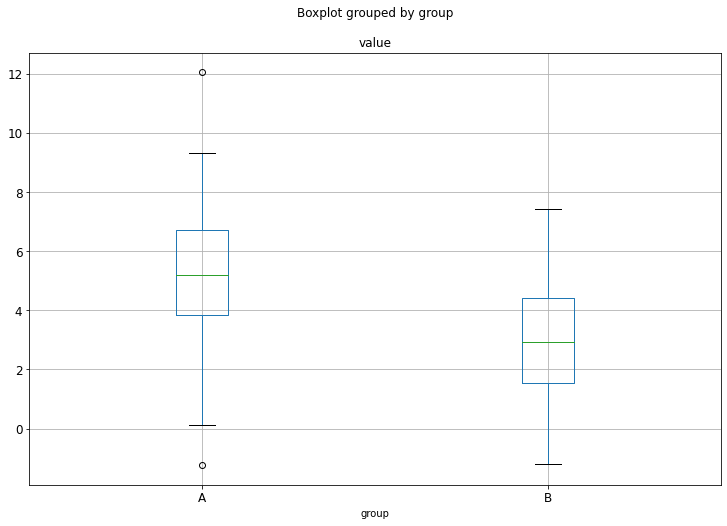

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd

# draw two random samples from normal distribution
np.random.seed(28041990) # makeing sure that we draw the same points each time we repeat
s1 = np.random.normal(5, 2, 100)
s2 = np.random.normal(3, 2, 100)

# create a dataframe
norm_dict = {"group" : list(itertools.chain.from_iterable(itertools.repeat(x, 100) for x in ["A"])) 
             + list(itertools.chain.from_iterable(itertools.repeat(x, 100) for x in ["B"])) 
             , "value" : np.concatenate((s1,s2))}
ideal_pd = pd.DataFrame(data=norm_dict)

# plot normal data with equal variance
fig, ax = plt.subplots(figsize=(12,8))
bp = ideal_pd.boxplot(column=['value'], by='group', fontsize='large', ax=ax)

Ideally, you want to see equal length whiskers and no outliers. However, the above example shows that outliers, particularly evenly distributed ones, are "kind of normal" for data from a normal distribution!

The **Welch t-test** is very similar to the "classical" t-Test. Assumptions are normal distribution as well as independence of data. But the Welch t-test is more tolerant to heterogeneity in variances.

A **paired t-Test** implies:

   * **Paired data**: A paired sample results from e.g. the investigation of the effect of two insecticides on different branches of the same tree.
   
   * **Normal distribution of the differences in mean** (Boxplot).

## Implementation

### The Function <tt>stats.ttest_ind()</tt> for Independent Samples

The following functions returns test statistic and p-value:

    stats.ttest_ind(x, y, equal_var = True, alternative = "two-sided")
    
<tt>x</tt> and <tt>t</tt> are expected to be numpy arrays. For a *classical* t-test, the default argument <tt>equal_var = True</tt> is correct. For a *Welch t-test* you need to switch this to <tt>False</tt>. Instead of a two-sided test, you can of course perfom a test with alternative hypothesis <tt>less</tt> or <tt>greater</tt>.

### Computing Confidence Intervals for Independent Samples

Confidence intervals need to be computed separately, and now it gets seemingly a bit complicated. First, we need to understand how

    statsmodels.stats.weightstats.CompareMeans.tconfint_diff(alpha, alternative = "two-sided", usevar = "pooled")
    
works. Regerattably, this function has different keywords compared to the previous. The $\alpha$-error should be float. <tt>alternative</tt> could instead be <tt>larger</tt> or <tt>smaller</tt>. <tt>uservar</tt> can be <tt>unequal</tt> for a Welch t-test.

Actually computing the confidence interval requires that you use the function

    statsmodels.stats.api.CompareMeans(Descr1, Descr2).tconfint_diff()
    
where <tt>Descr1</tt> and <tt>Descr2</tt> are an object of <tt>statsmodels.stats.api.DescrStatsW(X)</tt> that accepts a numpy array <tt>X</tt> with the values of your sample. It sounds a lot worse than it is in reality...

### Paired t-Test with <tt>stats.ttest_rel()</tt>

For paired samples, use this function:

    stats.ttest_rel(x, y, alternative = "two.sided")

The usage is similar to <tt>stats.ttest_ind()</tt>.


## Example "Wisconsin Fast Plant" (2)

Referring to data given in the Introduction (01), the question is now whether the two samples differ significantly in means ($\alpha$ = 5%).

In [23]:
brassica = pd.read_csv('data/brassica.csv', sep='\t')
brassica

,group,height
0,control,10.0
1,control,13.2
2,control,19.8
3,control,19.3
4,control,21.2
5,control,13.9
6,control,20.3
7,control,9.6
8,ancy,13.2
9,ancy,19.5


## Statistical Analysis

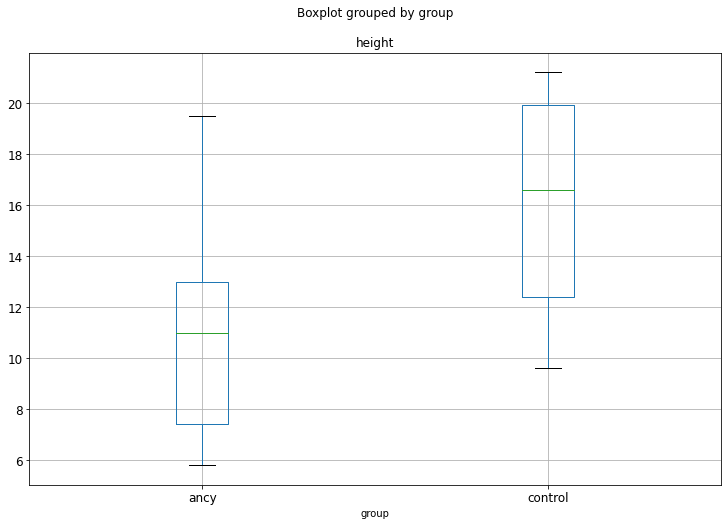

In [24]:
# plot data for inspection whether t-test is appropriate
fig, ax = plt.subplots(figsize=(12,8))
bp = brassica.boxplot(column=['height'], by='group', fontsize='large', ax=ax)

   * Approximate **normal distribution** is accepted because the median is located in the middle of both boxes 
   
   * Approximate **homogeneity of variances** because boxes/whiskers have similar length
   
   * **Continuous data** because height is indicated in cm
   
   * **Independency of data** because the plants were treated independent from each other.
   
$\Longrightarrow$ Data is suiting for the analysis with a classical t-Test. Ancymidol is a growth repressor. Therefore, a one-sided test with the expectation that Ancymidol treated plants are smaller than the control group is calculated. Hypotheses:

$$H_{0}: \mu_{control} \leq \mu_{ancy}$$

$$H_{1}: \mu_{control} > \mu_{ancy}$$

In [25]:
from scipy import stats
import statsmodels.stats.api as sms # make everything a bit more concise with alias

# spliting data into two arrays
X1 = brassica[brassica['group'] == 'control']['height']
X2 = brassica[brassica['group'] == 'ancy']['height']

# compute classical t-test with one-sided hypothesis - note that this does not work on the University Hub at the moment!
# print("t-Test:")
# print(stats.ttest_ind(X1, X2, equal_var=True, alternative="greater"))

# compute confidence interval
print("Confidence Interval:")
print(sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2)).tconfint_diff(alpha=0.05, 
                                                                         alternative="larger", usevar="pooled"))

Confidence Interval:
(0.5434019841709299, inf)


The test statistic is 1.991913923866896. This value is usually compared to a table value but luckily we do not need to do this because we have a p-value of 0.03390732402203314 at hand. The p-value is compared to the respective $\alpha$-error. The test result is significant if the p-value is smaller than $\alpha$.

<div class="alert alert-info"><b>Careful:</b>$\alpha$ must be set a priori before the test itself is calculated! </div>

Here, the plants treated with Ancymidol are significantly shorter than the non treated control group because 0.03390732402203314 $<$ 0.5. The alternative hypothesis is accepted. 

The 95% confidence interval for the difference of the true parameters $\mu_{control}$ - $\mu_{ancy}$ is displayed. If the experiment was repeated infinite times, the true difference would be located within the respective confidence interval in 95% of all cases. However, there is no statement about the current experiment in it.

<div class="alert alert-info"><b>In practice:</b> If the confidence interval includes zero, the test result is counted as not significant. If the result is significant (zero not included), the difference to zero represents a measure of rejection of the H$_{0}$-hypothesis. The interval width accounts for scattering and the number of observations. In general, confidence intervals are displayed in the original data's dimension: in this example measurements in centimeteres. </div>

The given confidence interval <tt>0.5434019841709299, inf</tt> indicates a significance to a confidence level of 0.95 because zero is excluded: $\mu_{control}$ - $\mu_{ancy}$ = 0 can be rejected with an error probability of 5%. More detailed, the confidence interval indicates that the control plants are at least 0.542402 cm higher than the Ancymidol treated plants. 

<font size="3"><div class="alert alert-warning"><b>Exercise 7.1:</b> <br> 

The infection of strawberries with small white worms leads to a reduction in harvest. It is possible to fight the parasite with disinfectants. An new additive is suspected to extend the effective period but side effects on the strawberry plants are still unknown. Five plots on a field have randomly been chosen to investigate the overall effect of the additive on strawberry plants. Each plot was randomly divided in two parts where one half was treated with the disinfectant without additive and the other half was treated with disinfectant and additive. The strawberry yield in presented in the code snipped below (Wonnacott and Wonnacott, 1990, p 273).

Develop convenient working hypotheses. Is the data normal distributed and homogeneous in variances? Which test do you choose? Interpret the output! 
</div>

In [26]:
import itertools

lst = ["standard"]
lst2 = ["additiv"]
strawb_dict = {"treatment" : list(itertools.chain.from_iterable(itertools.repeat(x, 5) for x in lst)) 
             + list(itertools.chain.from_iterable(itertools.repeat(x, 5) for x in lst2)),
             "response" :[109, 68, 82, 104, 93, 107, 72, 88, 101, 97]}

import pandas as pd

strawb_pd = pd.DataFrame(data=strawb_dict)
strawb_pd

,treatment,response
0,standard,109
1,standard,68
2,standard,82
3,standard,104
4,standard,93
5,additiv,107
6,additiv,72
7,additiv,88
8,additiv,101
9,additiv,97



<b>Try it yourself:</b></font>

**Example Solution:**

$$H_{0}: \mu_{standard} = \mu_{additiv}$$

$$H_{1}: \mu_{standard} \neq \mu_{additiv}$$

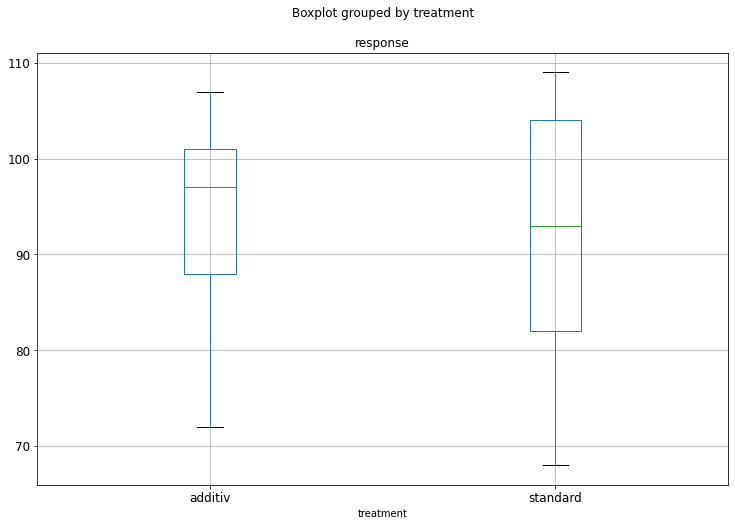

In [27]:
# plot data for inspection whether t-test is appropriate
fig, ax = plt.subplots(figsize=(12,8))
bp = strawb_pd.boxplot(column=['response'], by='treatment', fontsize='large', ax=ax)

In [38]:
# spliting data into two arrays
X1 = strawb_pd[strawb_pd['treatment'] == 'standard']['response']
X2 = strawb_pd[strawb_pd['treatment'] == 'additiv']['response']

# compute classical t-test with two-sided hypothesis
print("t-Test:")
print(stats.ttest_ind(X1, X2, equal_var=True))

# compute confidence interval
print("Confidence Interval:")
print(sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2)).tconfint_diff(alpha=0.05, usevar="pooled"))

t-Test:
Ttest_indResult(statistic=-0.18721581666031514, pvalue=0.8561523722878017)
Confidence Interval:
(-23.971243418985775, 20.37124341898578)


To a confidence level of 95\%, there is no significant difference. The very high p-value might rather be used as an indicator for equality which is a success for this experiment (looking for no effect on the strawberry plants). 

## Example: Root Growth of Mustard Seedlings

### Experiment

The influence of light and darkness on the root growth of mustard seedlings has been investigated in an experiment (Hand et al., 1994, p. 75). The question is if the length of roots differs for the two treatments, data shown below:


In [29]:
mustard = pd.read_csv('data/mustard.csv', sep='\t')
mustard

,treatment,response
0,grown.with.light,21
1,grown.with.light,39
2,grown.with.light,31
3,grown.with.light,13
4,grown.with.light,52
5,grown.with.light,39
6,grown.with.light,55
7,grown.with.light,50
8,grown.with.light,29
9,grown.with.light,17


### Statistical Analysis

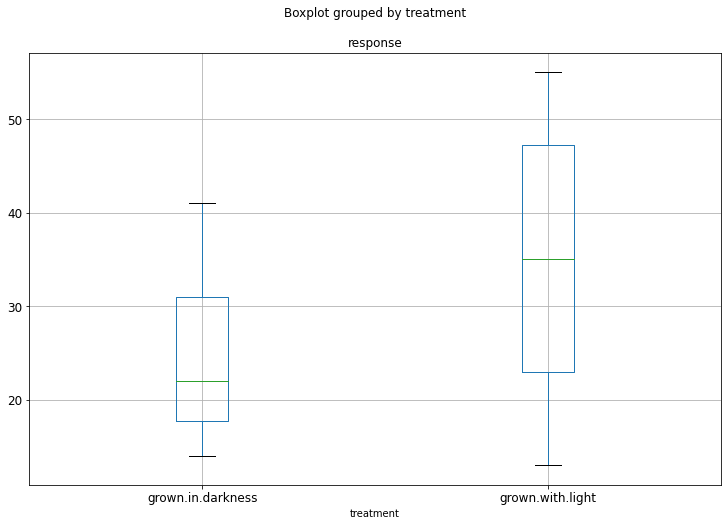

In [30]:
# plot data for inspection whether t-test is appropriate
fig, ax = plt.subplots(figsize=(12,8))
bp = mustard.boxplot(column=['response'], by='treatment', fontsize='large', ax=ax)

   * Approximate **normal distribution** (see boxplot) and continuity of data (root length was measured in cm).
   
   * **Heterogeneity of variances** (see boxplot, boxes differ in length), this implies Welch t-Test
   
   * The different treatments are assumend to be **independent**.
   
A two-sided hypothesis is reasonable: the direction of a light effect on mustard roots is unknown. The $\alpha$-error is set on 5%. Pair of hypotheses: 

$$H_{0}: \mu_{light} = \mu_{dark}$$
$$H_{1}: \mu_{light} \neq \mu_{dark}$$

In [31]:
# spliting data into two arrays
X1 = mustard[mustard['treatment'] == 'grown.with.light']['response']
X2 = mustard[mustard['treatment'] == 'grown.in.darkness']['response']

print("t-Test:")
print(stats.ttest_ind(X1, X2, equal_var=False))

# compute confidence interval
print("Confidence Interval:")
print(sms.CompareMeans(sms.DescrStatsW(X1), 
                       sms.DescrStatsW(X2)).tconfint_diff(alpha=0.05, 
                                                          usevar="unequal"))

t-Test:
Ttest_indResult(statistic=1.774823934929885, pvalue=0.09638277750258639)
Confidence Interval:
(-1.9775302939885737, 21.577530293988573)


The p-value is greater than 0.05. Therefore, the roots of mustard seedlings grown with light and in darkness do not differ significantly with an error probability of 5%. It would have been possible to compare the p-value with another $\alpha$, e.g. 0.1. In this case, the result would have been significant. But as mentioned before, the $\alpha$-error has to be set a priori before calculating the test. 

Zero is included in the confidence interval which means that the test result is not significant to a confidence level of 95%. 

Plants grown in darkness have an average root length of 24.8 cm, whereas the group treated with light has an average root length of 34.6 cm.

This test result leads to the conclusion that the null hypothesis cannot be rejected to a confidence level of 0.95. However, this does not assure the equality of the two samples because a t-test is not checking for homogeneity. 

<font size="3"><div class="alert alert-warning"><b>Exercise 7.2:</b> <br> 

"Two varieties of lettuce were grown for 16 days in a controlled environment. Data below shows the total dry weight (in g) of the leaves of nine plants of the variety *Salad Bowl* and six plants of the variety *Bibb*." (Knight and Mitchell, 1983, cited according to Samuels and Wittmer, 2003, p. 226, author states that the actual sample sizes were equal; some observations have been omitted).

Find adequate hypotheses. Is the data normal distributed and homogeneous in variances? Which test do you choose? Interpret the output!
</div>

In [32]:
lettuce = pd.read_csv('data/lettuce.csv', sep='\t')
lettuce

,variety,weight
0,bowl,3.06
1,bowl,2.78
2,bowl,2.87
3,bowl,3.52
4,bowl,3.81
5,bowl,3.60
6,bowl,3.30
7,bowl,2.77
8,bowl,3.62
9,bibb,1.31


<b>Try it yourself:</b></font>

**Example Solution:**

Two-sided test (because no tendency is expected):

$$H_{0}: \mu_{bowl} = \mu_{bibb}$$

$$H_{1}: \mu_{bowl} \neq \mu_{bibb}$$

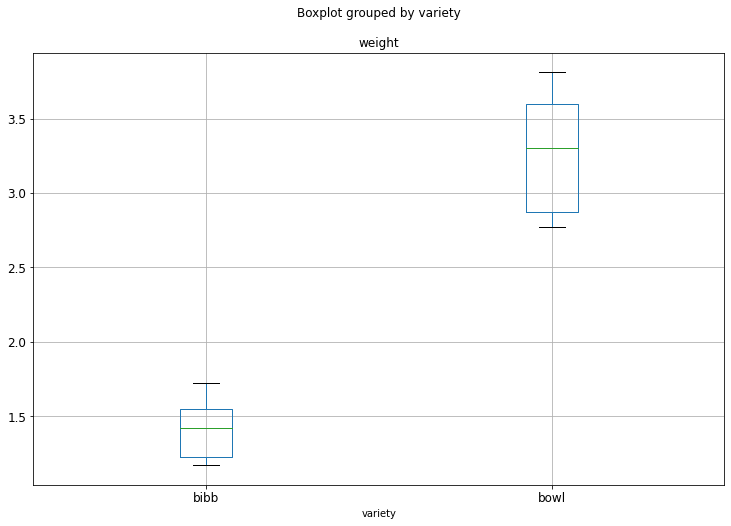

In [33]:
# plot data for inspection whether t-test is appropriate
fig, ax = plt.subplots(figsize=(12,8))
bp = lettuce.boxplot(column=['weight'], by='variety', fontsize='large', ax=ax)

   * Approximate normal distributio
   * Boxes are different in length, therefore heterogeneity in variances is concluded. 
   * Independent data.

$\Longrightarrow$ Welch t-test

In [34]:
X1 = lettuce[lettuce['variety'] == 'bibb']['weight']
X2 = lettuce[lettuce['variety'] == 'bowl']['weight']

print("t-Test:")
print(stats.ttest_ind(X1, X2, equal_var=False))

print("Confidence Interval:")
print(sms.CompareMeans(sms.DescrStatsW(X1), 
                       sms.DescrStatsW(X2)).tconfint_diff(alpha=0.05, 
                                                          usevar="unequal"))

t-Test:
Ttest_indResult(statistic=-11.483595693288514, pvalue=4.421524636751332e-08)
Confidence Interval:
(-2.1935419805426988, -1.4975691305684127)


The lettuce varieties differ significantly in dry weight with an error probability of 5%. This is also supported by the confidence interval.

## Example: Growth Induction

In an experiment, a certain treatment is supposed to initiate growth induction. 20 plants have been divided in two groups by fitting pairs that are as similar as possible. One group was treated, the other was left as a control (data shown below) (Mead at al., 2003, p. 73).

In [35]:
growth = pd.read_csv('data/growth.csv', sep='\t')
growth

,treatment,height
0,treated,7
1,treated,10
2,treated,9
3,treated,8
4,treated,7
5,treated,6
6,treated,8
7,treated,9
8,treated,12
9,treated,13


Since this an experiment with paired samples, we will inspect whether the differences between samples are normal distributed:

<AxesSubplot:>

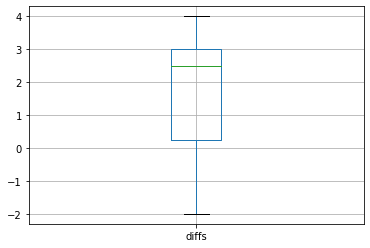

In [36]:
X1 = growth[growth['treatment'] == 'treated']['height']
X2 = growth[growth['treatment'] == 'control']['height']
diffs = np.array(X1) - np.array(X2)
diffs_dict = {'diffs' : diffs}
diffs_pd = pd.DataFrame(data=diffs_dict)
diffs_pd.boxplot()

   * Approximate **normal distribution** of pair differences (boxplot, the test is assumed to be robust to a median which is not perfectly located in the boxes' middle).

   * **Paired data** because plant pairs that are as similar as possible have been formed. 
   
Paired one-sided t-test (because it is expected that a growth inductor created taller plants, i.e. $\mu$ is greater 0 in H$_{0}$). 

In [37]:
# Note that this currently does not work on the University JupyterHub
# print(stats.ttest_rel(X1, X2, alternative = "greater"))
sms.DescrStatsW(diffs).tconfint_mean(alternative="larger")

(0.476398071008447, inf)

The p-value is smaller than 0.05. For this reason, the test result is significant. A treatment for growth induction results in a stronger plant growth. The confidence interval confirms this.